# Results Analysis

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2013-01-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

In [4]:
splitting_time

datetime.datetime(2014, 4, 17, 0, 0)

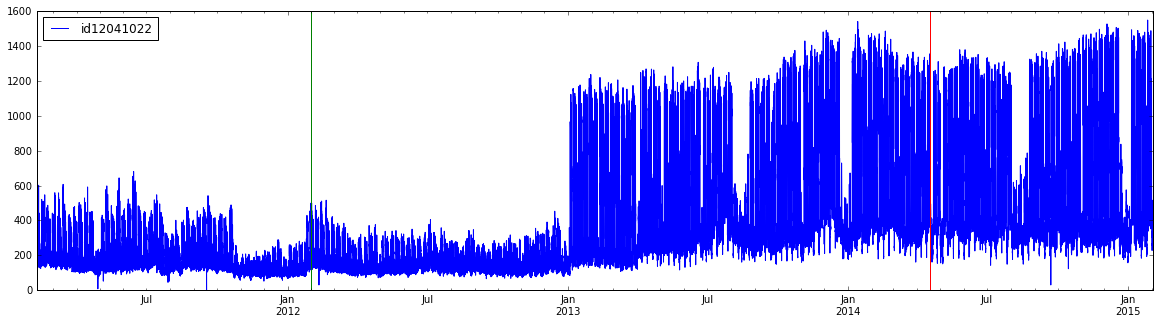

In [5]:
f = original_data[["id12041022"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [6]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
#from neural_network import PyBrainNN

C:\Python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Creating Feature Sets

In [7]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [8]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [9]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [10]:
horizons = range(1,25)

baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [#{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          #{'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=16)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             #{'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             #{'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [11]:
results_df = pd.DataFrame()

In [12]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[],[]], names=['horizon', 'testing_day','dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

#results_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[]], names=['horizon', 'ts']))
results_df = pd.DataFrame()

output_file_name = "tesi_id12041022.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#horizons = [2, 10]
horizons = [20]
#horizons = range(1,25)


def start_prediction_valuation(verbose=False):
    
    arr = []

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041022']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0]) # this is the reason for differences in baseline results (we use original_data in first which is wrong)
            #original_splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0] # here as well
            splitting_point = int(0.8 * original_data.shape[0])
            original_splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = original_splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create training vectors
            X_train = training_data[ar_wf_dt_ftrs].values
            y_train = training_data[["shifted_measurement"]].values.ravel()
            #print "Using dummy features:", X_train.shape

            # Create testing vectors
            X_test = testing_data[ar_wf_dt_ftrs].values
            y_test = testing_data[["shifted_measurement"]].values.ravel()
            
            # Initializing model
            mdl = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=16)
            mdl.fit(X_train,y_train)
            pred = mdl.predict(X_test)
            

            # Prepare results df
            results_df = testing_data[["shifted_measurement"]]
            results_df.rename(columns={"shifted_measurement":"true"}, inplace=True)

            results_df['last value'] = testing_data[["measurement"]]
            results_df['previous day'] = testing_data[["shifted_measurement_1d"]]
            results_df['previous week'] = testing_data[["shifted_measurement_1w"]]           
            
            results_df['offline'] = mdl.predict(X_test)
            results_df['batch'] = np.nan
            
            arr.append(results_df)
            
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]
                
                # init temoporary batch datafreame
                batch_df_temp = pd.DataFrame(index = testing_data.index)

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            bl = eval(baseline['init'])

                            for metric in error_metrics:
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                               y_test, testing_data[bl.target])
                                else:
                                    error = metric['function'](y_test, testing_data[bl.target])

                                validation_df.loc[(horizon, splitting_time, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                    else:    
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                                
                            # predictions
                            pred = mdl.predict(X_test)
                            batch_df_temp['batch'] = pred
                                
                            runtime = time.time() - start # Calculate runtime
                            
                            results_df.update(batch_df_temp)

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                            for metric in error_metrics:
                                #print "\t-->Error metric: {}".format(metric['name'])

                                if model['name'] == "Ridge Regression":
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                                   y_test_dummy, mdl.predict(X_test_dummy))
                                    else:
                                        error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                                else: 
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                                   y_test, mdl.predict(X_test))
                                    else:
                                        error = metric['function'](y_test, mdl.predict(X_test))

                                #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                                validation_df.loc[(horizon, splitting_time, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

            
                #print results_df
        
        all_results = pd.concat(arr, keys=horizons)
        all_results.index.set_names(['horizons', 'values'], inplace=True)

        print all_results
        
        all_results.to_csv(output_file_path)
        
start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

#output_file_name = "testni_eval_top20_id12041992.csv"
#output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

Working with sensor: id12041022

	-->Prediction horizont: 20h. Shifting runtime: 0.73s

C:\Python27\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
C:\Python27\lib\site-packages\ipykernel\__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\ipykernel\__main__.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\ipykernel\__main__.py:88: Setting



		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
					-->R2: -38.133
					-->MAE: 366.443
					-->MAPE: 89.605
					-->MASE: 1.985
				-->Computing Previous day
					-->R2: -34.387
					-->MAE: 333.864
					-->MAPE: 79.128
					-->MASE: 1.808
				-->Computing Previous week
					-->R2: -32.120
					-->MAE: 354.625
					-->MAPE: 84.096
					-->MASE: 1.921
			-->Dataset: TOP_20. X_train: (77376L, 20L), y_train: (77376L,)
				-->Training model: Random Forest, runtime: 11.40s
					-->R2: -32.650
					-->MAE: 332.175
					-->MAPE: 78.803
					-->MASE: 1.799

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
					-->R2: -6.057
					-->MAE: 105.923
					-->MAPE: 39.408
					-->MASE: 0.573
				-->Computing Previous day
					-->R2: -8.978
					-->MAE: 130.673
					-->MAPE: 46.102
					-->MASE: 0.707
				-->Computing Previous 

In [13]:
# read from csv
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1])

test

true  last value  previous day  previous week  \
horizons values                                                                
20       2014-04-17 00:00:00  688.0       442.0         688.0          804.1   
         2014-04-17 00:15:00  689.2       431.1         688.2          820.0   
         2014-04-17 00:30:00  683.4       419.3         660.0          825.2   
         2014-04-17 00:45:00  678.2       425.2         650.5          821.0   
         2014-04-17 01:00:00  667.0       407.0         654.0          797.8   
         2014-04-17 01:15:00  613.1       383.1         625.1          766.0   
         2014-04-17 01:30:00  582.0       381.1         591.1          789.1   
         2014-04-17 01:45:00  508.2       375.1         578.1          710.1   
         2014-04-17 02:00:00  449.3       362.5         493.0          579.1   
         2014-04-17 02:15:00  397.1       484.1         459.5          535.1   
         2014-04-17 02:30:00  417.0       448.0         437.0          535.1   
         2014-04-17 02:45:00  397.1       418.1         432.1          531.0   
         2014-04-17 03:00:00  378.1       396.1         446.0          441.2   
         2014-04-17 03:15:00  385.5       416.3         444.6          409.2   
         2014-04-17 03:30:00  374.1       405.1         426.0          428.2   
         2014-04-17 03:45:00  385.1       387.1         428.2          425.4   
         2014-04-17 04:00:00  409.0       386.0         442.0          409.1   
         2014-04-17 04:15:00  406.3       378.2         431.1          405.0   
         2014-04-17 04:30:00  359.1       426.4         419.3          413.2   
         2014-04-17 04:45:00  361.1       426.2         425.2          409.0   
         2014-04-17 05:00:00  368.1       438.0         407.0          423.1   
         2014-04-17 05:15:00  393.1       593.2         383.1          387.0   
         2014-04-17 05:30:00  367.0       604.2         381.1          377.2   
         2014-04-17 05:45:00  368.5       646.1         375.1          377.3   
         2014-04-17 06:00:00  357.1       694.1         362.5          384.1   
         2014-04-17 06:15:00  367.1       942.0         484.1          471.4   
         2014-04-17 06:30:00  354.3      1065.0         448.0          490.2   
         2014-04-17 06:45:00  353.1      1130.0         418.1          459.0   
         2014-04-17 07:00:00  332.1      1222.1         396.1          453.2   
         2014-04-17 07:15:00  354.1      1307.0         416.3          442.0   
...                             ...         ...           ...            ...   
         2015-01-31 20:30:00  422.5       408.2         401.5          351.5   
         2015-01-31 20:45:00  433.6       414.2         390.6          339.0   
         2015-01-31 21:00:00  454.5       382.7         390.4          345.3   
         2015-01-31 21:15:00  474.2       371.0         447.9          360.9   
         2015-01-31 21:30:00  514.8       366.5         456.4          376.4   
         2015-01-31 21:45:00  506.9       364.3         453.3          402.6   
         2015-01-31 22:00:00  486.3       370.2         433.5          380.7   
         2015-01-31 22:15:00  440.5       383.5         450.7          333.6   
         2015-01-31 22:30:00  428.9       370.7         447.4          373.0   
         2015-01-31 22:45:00  441.8       333.2         426.9          390.0   
         2015-01-31 23:00:00  429.3       331.5         452.4          391.1   
         2015-01-31 23:15:00  459.5       325.9         415.8          390.9   
         2015-01-31 23:30:00  472.9       328.3         398.1          432.4   
         2015-01-31 23:45:00  441.4       337.8         371.9          374.7   
         2015-02-01 00:00:00  428.3       344.6         393.8          345.5   
         2015-02-01 00:15:00  423.6       320.0         397.6          348.2   
         2015-02-01 00:30:00  448.7       315.8         408.2          332.9   
         2015-02-01 00:45:00  4

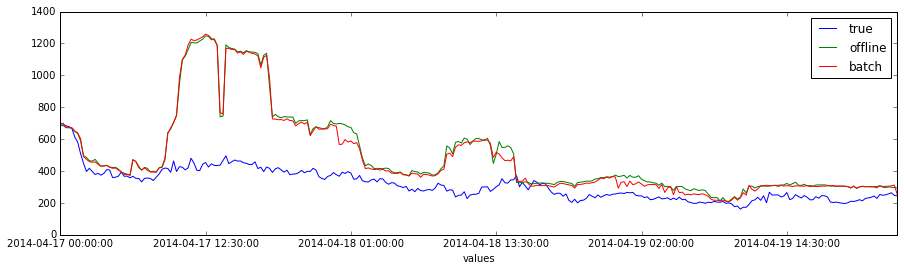

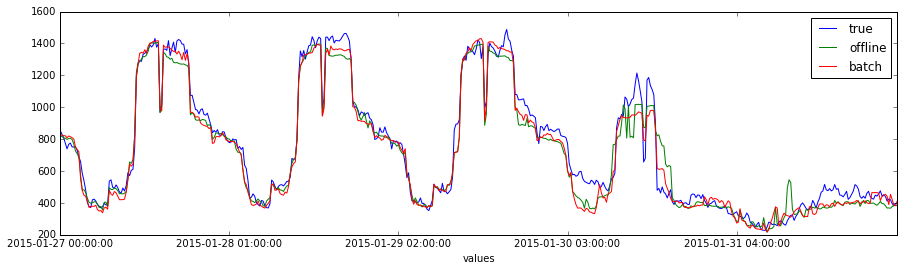

In [14]:
test.loc[20]['2014-04-17 00:00:00':'2014-04-20 00:00:00'][['true','offline','batch']].plot(figsize=(15,4))
test.loc[20]['2015-01-27 00:00:00':'2015-02-01 23:59:00'][['true','offline','batch']].plot(figsize=(15,4))

In [15]:
a=test.loc[20].groupby(test.index.to_datetime().dayofyear, sort=False).mean()
a

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


TypeError: <type 'tuple'> is not convertible to datetime

In [16]:
from sklearn.metrics import r2_score

def r2( g ):
    r2_lv = r2_score( g['true'], g['last value'] )
    r2_pd = r2_score( g['true'], g['previous day'] )
    r2_pw = r2_score( g['true'], g['previous week'] )
    r2_offline = r2_score( g['true'], g['offline'] )
    r2_batch = r2_score( g['true'], g['batch'] )
    return pd.Series( dict(  r2_lv=r2_lv, r2_pd=r2_pd, r2_pw=r2_pw, r2_offline=r2_offline, r2_batch=r2_batch ) )

#subset = test['2014-04-17 00:00:00':'2014-04-27 00:00:00']
subset = test.loc[20]['2015-01-05 00:00:00':'2015-02-01 23:59:00']
#subset = test['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)
a

C:\Python27\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


,r2_batch,r2_lv,r2_offline,r2_pd,r2_pw
5,0.902112,-0.523683,0.871533,0.676658,-1.924356
6,0.958999,-0.311814,0.954738,0.983248,-3.142257
7,0.954262,-0.237250,0.817736,0.987545,-3.294934
8,0.940462,-0.386345,0.728716,0.928803,-1.180523
9,0.879415,-3.774695,0.867006,-2.466987,-0.560880
10,0.705531,-32.352578,0.655883,-33.563672,0.069094
11,0.968179,-1.066683,0.954413,-1.191521,0.952132
12,0.948134,-0.327135,0.929714,0.872044,0.938378
13,0.885365,-0.173000,0.980978,0.971693,0.968808
14,0.959624,-0.288703,0.973201,0.976642,0.959743


Bar plot for last month. Major improvement for batch is not visible.

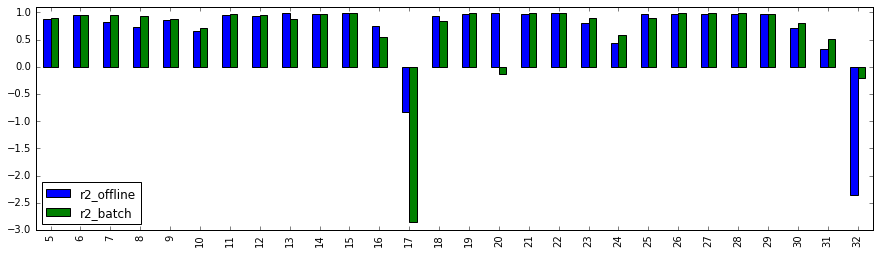

In [17]:
a[['r2_offline','r2_batch']].plot( kind='bar', figsize=(15,4), ylim=(-3, 1.1))

Diff is not very informative

C:\Python27\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


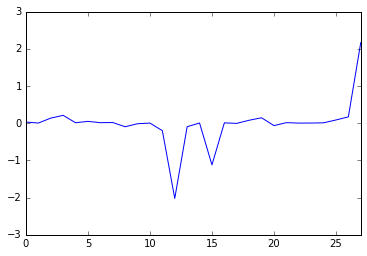

In [18]:
#subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]
b['diff'] = b['r2_batch'] - b['r2_offline']
b.reset_index()['diff'].plot()

Scatter plot for entire testing dataset.

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  from ipykernel import kernelapp as app


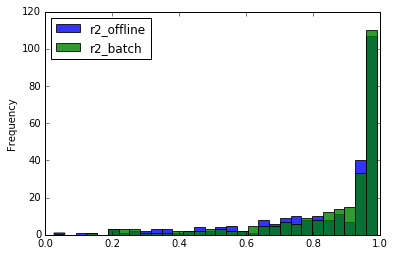

In [19]:
subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]
#a[['r2_offline','r2_batch']].plot( kind='hist', figsize=(15,4))
#a[['r2_offline','r2_batch']].hist(figsize=(15,4), bins=20)
#a[['r2_offline','r2_batch']].plot.hist(bins=30)
b[b > 0].plot.hist(bins=30, alpha=0.8)

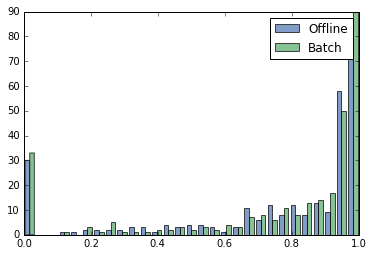

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

b = a[['r2_offline','r2_batch']]

c = b[b > 0].reset_index()[['r2_offline','r2_batch']]

c = c.fillna(0)

x = c["r2_offline"].values
y = c["r2_batch"].values
data = np.vstack([x, y]).T
bins = np.linspace(0, 1, 30)

plt.hist(data, bins, alpha=0.7, label=['Offline', 'Batch'])
plt.legend(loc='upper right')
plt.show()

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  from ipykernel import kernelapp as app


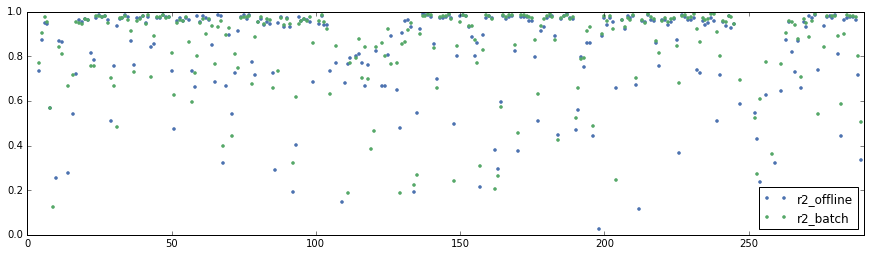

In [21]:
subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]

#a[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='*')
b[b > 0].reset_index()[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='.', linestyle='')

Scatter plot for entire testing dataset with regression plot trend, showing that Batch is better. Unfortunatelly the trend is downword. Maybe try with different sensor.

C:\Python27\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


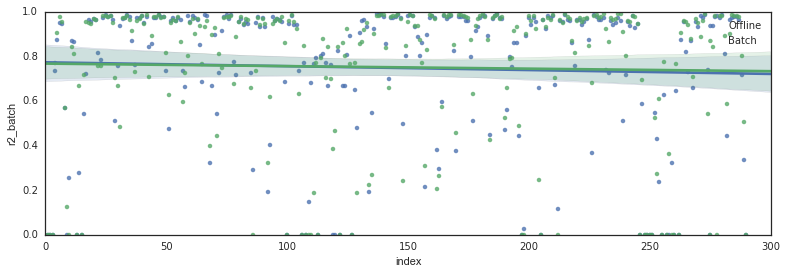

In [62]:
import seaborn as sns

sns.set_style("white")

subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]

#c = b.reset_index()[['r2_offline','r2_batch']]
c = b[b > 0].reset_index()[['r2_offline','r2_batch']]
c = c.fillna(0)
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="r2_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,1))
sns.regplot(y="r2_batch", x="index", data=c, label='Batch');

plt.legend(loc='upper right')
plt.show()

In [63]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

Offline slope: -0.000173491063416
Batch slope: -0.000113295313032


## MAPE analysis

In [25]:
import regression_metrics as additional_metrics

def mape(g):
    mape_lv = additional_metrics.mean_absolute_percentage_error( g['true'], g['last value'] )
    mape_pd = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous day'] )
    mape_pw = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous week'] )
    mape_offline = additional_metrics.mean_absolute_percentage_error( g['true'], g['offline'] )
    mape_batch = additional_metrics.mean_absolute_percentage_error( g['true'], g['batch'] )
    return pd.Series( dict(  mape_lv=mape_lv, mape_pd=mape_pd, mape_pw=mape_pw, mape_offline=mape_offline, mape_batch=mape_batch ) )

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  from ipykernel import kernelapp as app


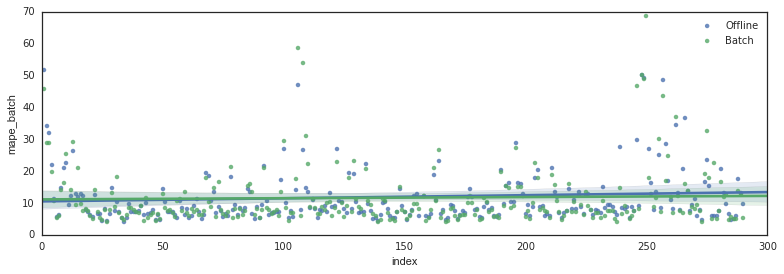

In [54]:
subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(mape)
a

b = a[['mape_offline','mape_batch']]

c = b[b > 0].reset_index()[['mape_offline','mape_batch']]
c = c.fillna(0)
#c = b.reset_index()[['mape_offline','mape_batch']]
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="mape_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,70))
sns.regplot(y="mape_batch", x="index", data=c, label='Batch');

plt.legend(loc='upper right')
plt.show()

In [41]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

Offline slope: 0.00964979672473
Batch slope: 0.00364782595334


## Future work

- more horizons
- more sensors
- online approach